In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa

from birdsong.utils import get_folders_labels


## **Implementing sensory memory in digital spectral representations**

Can be done by using a **circular buffer** to store a predetermined number of spectra at previous timesteps. <br>

A circular buffer is a data structure consisting of an array which is treated as circular, where its indices loop back to 0 after the array’s length is reached.

Each indice of the circular buffer holds a full frequency spectrum for a specific timestep. As new spectra are calculated, they are written to the buffer, overwriting the oldest timesteps if the buffer is already full.

Here is an example of a circular buffer in Python adapted from [Eric Wieser](https://github.com/eric-wieser/numpy_ringbuffer):

In [2]:

class CircularBuffer():
    # Initializes NumPy array and head/tail pointers
    def __init__(self, capacity, dtype=float):
        self._buffer = np.zeros(capacity, dtype)
        self._head_index = 0
        self._tail_index = 0
        self._capacity = capacity
    # Makes sure that head and tail pointers cycle back around
    def fix_indices(self):
        if self._head_index >= self._capacity:
            self._head_index -= self._capacity
            self._tail_index -= self._capacity
        elif self._head_index < 0:
            self._head_index += self._capacity
            self._tail_index += self._capacity
    # Inserts a new value in buffer, overwriting old value if full
    def insert(self, value):
        if self.is_full():
            self._head_index += 1
        self._buffer[self._tail_index % self._capacity] = value
        self._tail_index += 1
        self.fix_indices()

    # Returns the circular buffer as an array starting at head index
    def unwrap(self):
        return np.concatenate((
            self._buffer[self._head_index:min(self._tail_index, self._capacity)],
            self._buffer[:max(self._tail_index - self._capacity, 0)]
        ))
    # Indicates whether the buffer has been filled yet
    def is_full(self):
        return self.count() == self._capacity
    # Returns the amount of values currently in buffer
    def count(self):
        return self._tail_index - self._head_index


## **Dilated convolution**

Under the assumption that the most recent incoming frequency data is the largest determining factor in momentary sound analysis, a **dilated spectral buffer** could be a useful tool for reducing the size of computational memory.

By dilating each timestep in a new buffer by some ratio (such as an exponential incrementation of 2^t, for example) in proportion to the original buffer, the dimensionality can be drastically reduced while retaining a high resolution of spectral developments at the most recent timesteps.

The driving concept behind a dilated spectral buffer is to keep the most recent spectral impressions in memory while also retaining some information about the “big picture” context in an efficient way.

Below is a simplified code snippet for making dilated spectral frames using a Gammatone filterbank. **Note**: this example uses offline processing, but the filterbank can be applied real-time as well, inserting spectral frames to a circular buffer.

In [3]:
# Filterbank to separate input audio signals into multiple components

from gammatone import gtgram

class GammatoneFilterbank:
    # Initialize Gammatone filterbank
    def __init__(self,
                 sample_rate,
                 window_time,
                 hop_time,
                 num_filters,
                 cutoff_low):
        self.sample_rate = sample_rate
        self.window_time = window_time
        self.hop_time = hop_time
        self.num_filters = num_filters
        self.cutoff_low = cutoff_low
    # Make a spectrogram from a number of audio samples
    def make_spectrogram(self, audio_samples):
        return gtgram.gtgram(audio_samples,
                             self.sample_rate,
                             self.window_time,
                             self.hop_time,
                             self.num_filters,
                             self.cutoff_low)
    # Divide audio samples into dilated spectral buffers
    def make_dilated_spectral_frames(self,
                                     audio_samples,
                                     num_frames,
                                     dilation_factor):
        spectrogram = self.make_spectrogram(audio_samples)
        spectrogram = np.swapaxes(spectrogram, 0, 1)
        dilated_frames = np.zeros((len(spectrogram),
                                  num_frames,
                                  len(spectrogram[0])))

        for i in range(len(spectrogram)):
            for j in range(num_frames):
                dilation = np.power(dilation_factor, j)

                if i - dilation < 0:
                    dilated_frames[i][j] = spectrogram[0]
                else:
                    dilated_frames[i][j] = spectrogram[i - dilation]

        return dilated_frames


## **Implement a Seq2Seq autoencoder with Keras to produce audio embeddings**

Below is a code snippet for a "Listener Network", whose purpose is to “listen” to incoming sequences of sounds and reduce them to a more compact and meaningful representation which we can then analyze and process.

In [4]:
import os
from birdsong.config import config
from birdsong.audiotransform.to_image import AudioPreprocessor


In [5]:
sample_dir = '/Users/ramansheshka/code/Raman-Sheshka/birdsong_classifier/raw_data/split_data'
sample_file = 'XC48486_2.mp3'
sample_file_path = os.path.join(sample_dir,"calqua", sample_file)
print(sample_file_path)
os.path.isfile(sample_file_path)


/Users/ramansheshka/code/Raman-Sheshka/birdsong_classifier/raw_data/split_data/calqua/XC48486_2.mp3


True

In [6]:
sample_rate = 45000
window_time = 10
hop_time = 42
num_filters = 100
cutoff_low = 20
filter_audio = GammatoneFilterbank(sample_rate,
                 window_time,
                 hop_time,
                 num_filters,
                 cutoff_low)


In [7]:
import librosa
from pydub import AudioSegment


44100

1

2

3.0

22050


(66150,)

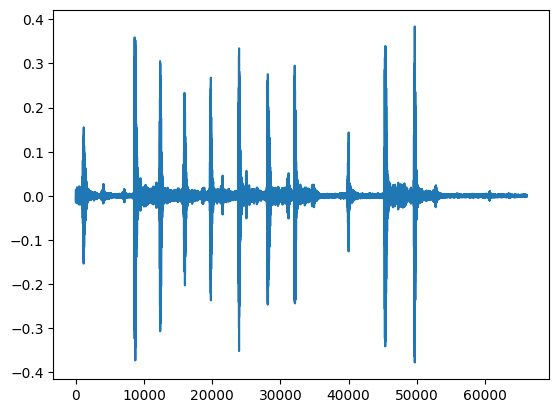

In [8]:
sound = AudioSegment.from_file(sample_file_path, format='mp3')
display(sound.frame_rate)
display(sound.channels)
display(sound.sample_width)
display(sound.duration_seconds)
raw_audio = np.asarray(sound.get_array_of_samples())
raw_audio.shape

librosa_wave, sr = librosa.load(sample_file_path)
print(sr)
display(librosa_wave.shape)

plt.plot(librosa_wave)


In [9]:
librosa_wave.shape[0] / 0.025


2646000.0

In [10]:
sample_rate = sr
window_time = 0.05#s
hop_time =  0.25 * window_time #s
num_filters = 21
cutoff_low = 20
filter_audio = GammatoneFilterbank(sample_rate,
                 window_time,
                 hop_time,
                 num_filters,
                 cutoff_low)
D = filter_audio.make_spectrogram(librosa_wave)


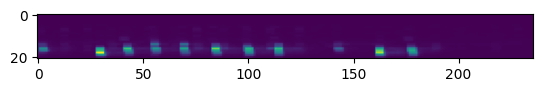

In [11]:
# import matplotlib.pyplot as plt

plt.imshow(D)


In [12]:
num_frames = 45
dilation_factor = 2
Df = filter_audio.make_dilated_spectral_frames(
                                     librosa_wave,
                                     num_frames,
                                     dilation_factor)


In [13]:
Df_most_recent = Df[:,0,:]
display(Df_most_recent.shape)


(236, 21)

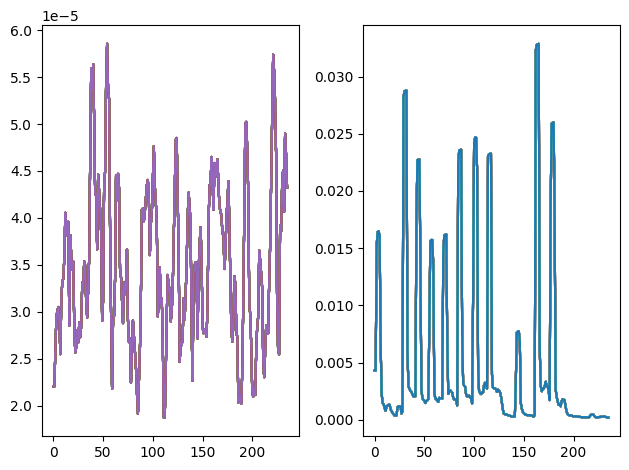

In [14]:
n_r,n_frames,n_filtres = Df.shape
fig, axes = plt.subplots(nrows=1, ncols=2)
for j in range(n_frames):
    axes[0].plot(Df[:,0,3])

for k in range(n_filtres):
    axes[1].plot(Df[:,0,17])

plt.tight_layout()


In [15]:
(45 * 236) /0.05


212400.0

In [31]:
# def construct_lstm_dataset(parent_folder):
#     X = np.ndarray()
#     y = []
#     iterator = 0
#     species_folders_labels = get_folders_labels(parent_folder)
#     for species_label in species_folders_labels:
#         species_folder_label_path = os.path.join(species_folders_labels, species_label)
#         files_in_species_folder = list_files_in_folder(species_folder_label_path)
#         for file in files_in_species_folder:
#             X[iterator,:,:] = apply_gammatone(file)
#             y.append(species_label)
#             iterator += 1
#     return X,y


In [29]:
from birdsong.utils import get_folders_labels


In [16]:
# function to get gammatone from an audio file

# set gammatone params
window_time = 0.05#s
hop_time =  0.25 * window_time #s
num_filters = 21
cutoff_low = 20

num_frames = 10
dilation_factor = 2


# define the function to get gammatone
def get_gammatone(audio_file_path):
    librosa_wave_file, sr = librosa.load(audio_file_path)
    audio_filter = GammatoneFilterbank(sr,
                 window_time,
                 hop_time,
                 num_filters,
                 cutoff_low)
    gammatone = audio_filter.make_dilated_spectral_frames(librosa_wave_file,
                                                          num_frames,
                                                          dilation_factor)
    # we lilit us ti only one frame, frame 0
    gammatone_most_recent = gammatone[:,0,:]
    return gammatone_most_recent


In [31]:
merlin_test_path = '/home/sheshka/code/Raman-Sheshka/birdsong_classifier/raw_data/split_data/merlin/XC195551_9.mp3'

toto = get_gammatone(merlin_test_path)
display(toto.shape)


/var/folders/59/__mg86nn4hx9y9ck3zxxr7680000gn/T/ipykernel_64694/1210829903.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa_wave_file, sr = librosa.load(audio_file_path)
/Users/ramansheshka/.pyenv/versions/3.10.6/envs/birdsong/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/home/sheshka/code/Raman-Sheshka/birdsong_classifier/raw_data/split_data/merlin/XC195551_9.mp3'

In [17]:
# function to transform audio signals into dilated spectral frames
import glob

def get_dataset_len(parent_folder):
    n = 0
    species_folders_labels = get_folders_labels(parent_folder)
    for species_label in species_folders_labels:
        species_folder_label_path = os.path.join(parent_folder, species_label)
        n += len(glob.glob(os.path.join(species_folder_label_path,"*.mp3")))
    return n


def construct_lstm_dataset(parent_folder, num_timesteps, num_filters):

    n_rows = get_dataset_len(parent_folder)
    n_cols = num_timesteps
    n_states = num_filters

    X = np.zeros((n_rows, n_cols, n_states), dtype=np.float32)
    y = ['silence'] * n_rows

    species_folders_labels = get_folders_labels(parent_folder)
    iterator = 0
    for species_label in species_folders_labels:
        species_folder_label_path = os.path.join(parent_folder, species_label)

        files_in_species_folder = glob.glob(os.path.join(species_folder_label_path,"*.mp3"))
        for file_path in files_in_species_folder:
            try:
                X[iterator,:,:] = get_gammatone(file_path)
                y[iterator] = species_label
                iterator += 1
            except:
                pass
    return X,y


In [49]:
real_path = '/home/sheshka/code/Raman-Sheshka/birdsong_classifier/raw_data/split_data/'


In [37]:
N = get_dataset_len(real_path)
display(N)


40579

In [52]:
X, y = construct_lstm_dataset(real_path, 236, 21)


In [39]:
raw_data = '/Users/ramansheshka/code/Raman-Sheshka/birdsong_classifier/raw_data'
if os.path.isfile(os.path.join(raw_data, 'lstm.pkl')) and os.path.isfile(os.path.join(raw_data, 'lstm_y.pkl')):
    print('loading data from pickle')
    X = np.load(os.path.join(raw_data, 'lstm.pkl'), allow_pickle=True)
    y = np.load(os.path.join(raw_data, 'lstm_y.pkl'), allow_pickle=True)


loading data from pickle


In [40]:
X.shape


(40579, 236, 21)

```python
f = np.memmap('memmapped.dat', dtype=np.float32,
              shape=(nrows, ncols))
np.array_equal(f[:, -1], x)
````

In [41]:
display(X.shape)
display(len(y))


(40579, 236, 21)

40579

In [31]:
# normalize X?
layer = keras.layers.Normalization()
layer.adapt(data)
normalized_data = layer(data)


(40579, 236, 21)


/var/folders/59/__mg86nn4hx9y9ck3zxxr7680000gn/T/ipykernel_67853/1856695817.py:7: RuntimeWarning: invalid value encountered in divide
  X = (X - x_min)/(x_max-x_min)


In [38]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder


In [27]:
# turn target variable into binary class matrix


#y = tf.keras.utils.to_categorical(y, num_classes=3)
# y = to_categorical(y)
# y.shape

ohe = OneHotEncoder()
y = y.reshape(len(y), 1)
ohe.fit(y)
y = ohe.transform(y)


In [28]:
y.shape


(22, 3)

## **Autoencoder**

In [42]:
from keras import Model
from keras.layers import Input, LSTM, RepeatVector, Dense

def encoder(inputs, input_dim, latent_dim):
    encoder = LSTM(int(input_dim / 2),
                   activation="relu",
                   return_sequences=True)(inputs)
    encoder = LSTM(latent_dim,
                   activation="relu",
                   return_sequences=False)(encoder)
    return encoder


def decoder(latent_dim, timesteps, input_dim, encoder):
    decoder = RepeatVector(timesteps)(encoder)
    decoder = LSTM(int(input_dim / 2),
                   activation="relu",
                   return_sequences=True)(decoder)
    decoder = LSTM(input_dim,
                   return_sequences=True)(decoder)


    return decoder



def build_autoencoder(encoder, decoder, timesteps, input_dim, latent_dim):
    inputs = Input(shape=(timesteps, input_dim))
    encoded = encoder(inputs, input_dim, latent_dim)

    decoded = decoder(timesteps, input_dim, encoded)
    autoencoder = Model(inputs, decoded)
    return autoencoder


In [43]:
def prepare_listener(timesteps,
                     input_dim,
                     latent_dim,
                     optimizer_type,
                     loss_type):
    """Prepares Seq2Seq autoencoder model

        Args:
            :param timesteps: The number of timesteps in sequence
            :param input_dim: The dimensions of the input
            :param latent_dim: The latent dimensionality of LSTM
            :param optimizer_type: The type of optimizer to use
            :param loss_type: The type of loss to use

        Returns:
            Autoencoder model, Encoder model
    """

    inputs = Input(shape=(timesteps, input_dim))
    encoded = LSTM(int(input_dim / 2),
                   activation="relu",
                   return_sequences=True)(inputs)
    encoded = LSTM(latent_dim,
                   activation="relu",
                   return_sequences=False)(encoded)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(int(input_dim / 2),
                   activation="relu",
                   return_sequences=True)(decoded)
    decoded = LSTM(input_dim,
                   return_sequences=True)(decoded)

    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder.compile(optimizer=optimizer_type,
                        loss=loss_type,
                        metrics=['acc'])

    return autoencoder, encoder


In [44]:
autoencoder, encoder = prepare_listener(236, 21, 5,'adam', 'mse')


In [45]:
autoencoder.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 236, 21)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 236, 10)           1280      
                                                                 
 lstm_9 (LSTM)               (None, 5)                 320       
                                                                 
 repeat_vector_2 (RepeatVec  (None, 236, 5)            0         
 tor)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 236, 10)           640       
                                                                 
 lstm_11 (LSTM)              (None, 236, 21)           2688      
                                                           

In [46]:
encoder.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 236, 21)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 236, 10)           1280      
                                                                 
 lstm_9 (LSTM)               (None, 5)                 320       
                                                                 
Total params: 1600 (6.25 KB)
Trainable params: 1600 (6.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
layer = keras.layers.Normalization(axis=1)
layer.adapt(X)
normalized_data = layer(X)

In [49]:
normalized_data.shape

TensorShape([40579, 236, 21])

In [50]:
autoencoder.fit(normalized_data,normalized_data, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
1269/1269 [==============================] - 114s 89ms/step - loss: 0.9525 - acc: 0.1041
Epoch 2/50
1269/1269 [==============================] - 114s 90ms/step - loss: nan - acc: 0.1346
Epoch 3/50
 253/1269 [====>.........................] - ETA: 1:31 - loss: nan - acc: 0.1381

KeyboardInterrupt: 

In [ ]:
def predictor =
